In [1]:
matrix_destination = "matrix.cellQC.geneQC.normalised.ccClean.combat.sc3_clust.rds"
source("load_matrix.R")

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsp

# Clustering (Visual)

Clustering via PCA is influenced heavily by the variance of the data it computes PCS on, and which PCs are plotted against each other.

Let us iterate through the the top *n* most varying genes in our dataset and see how it affects the clustering for each value of n. We will plot only the first two components, and will not apply any colouring of the SC3 clusters computed in the earlier step.   

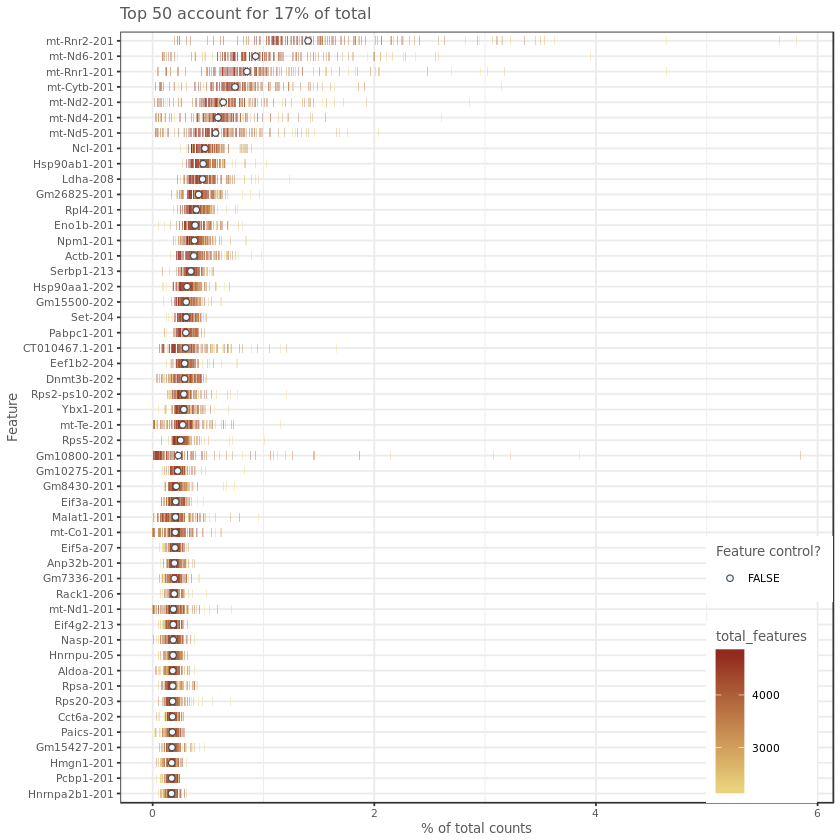

In [2]:
# First, a quick peek at our most expressive genes
plotQC(sce,type="high", n=50)

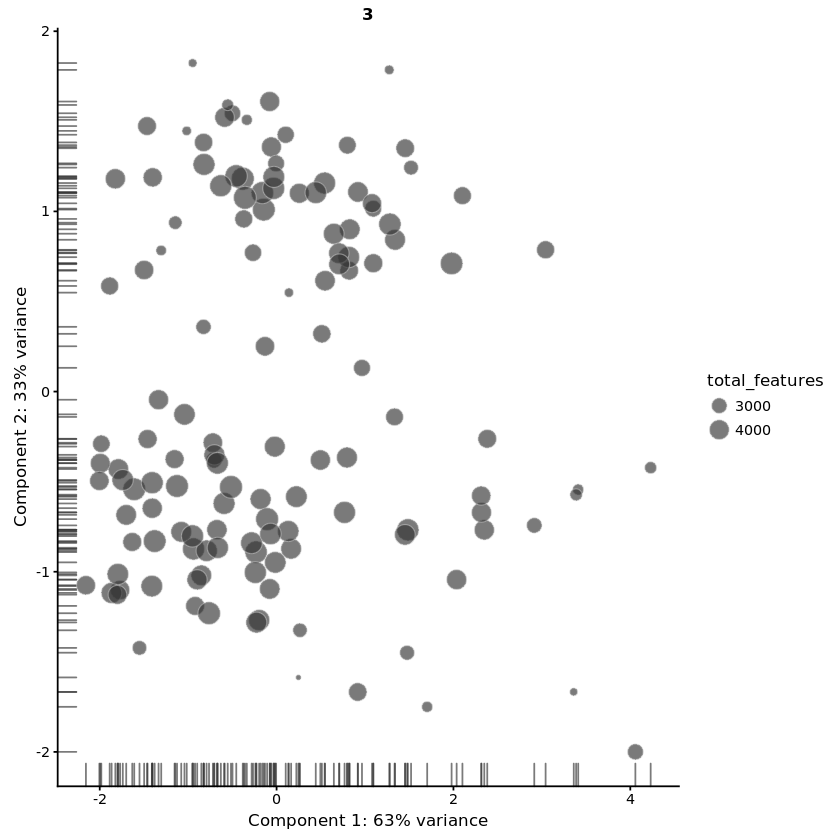

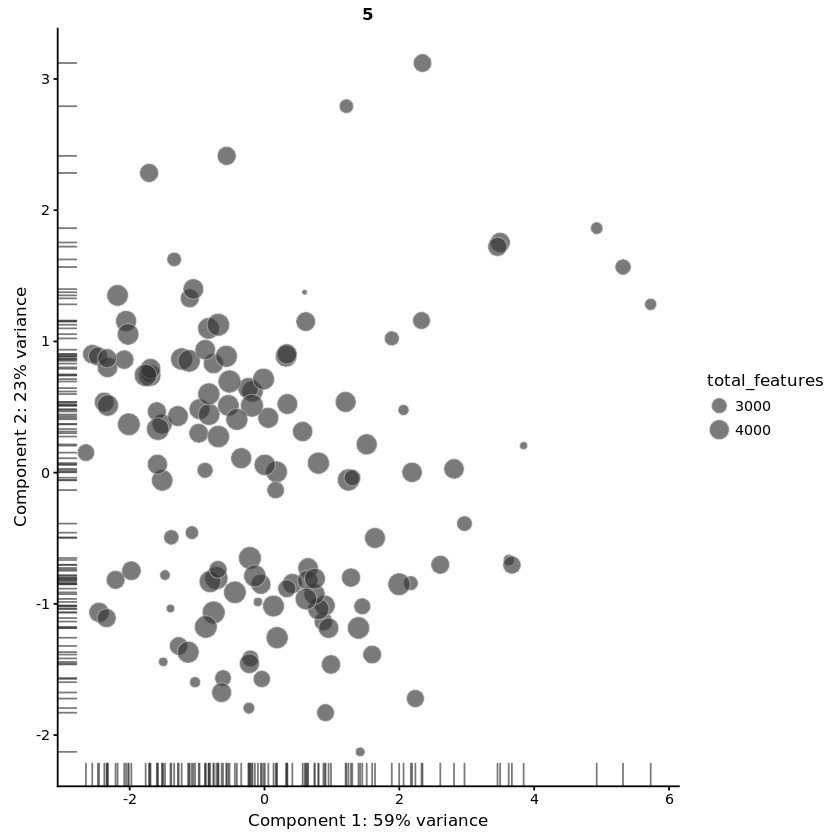

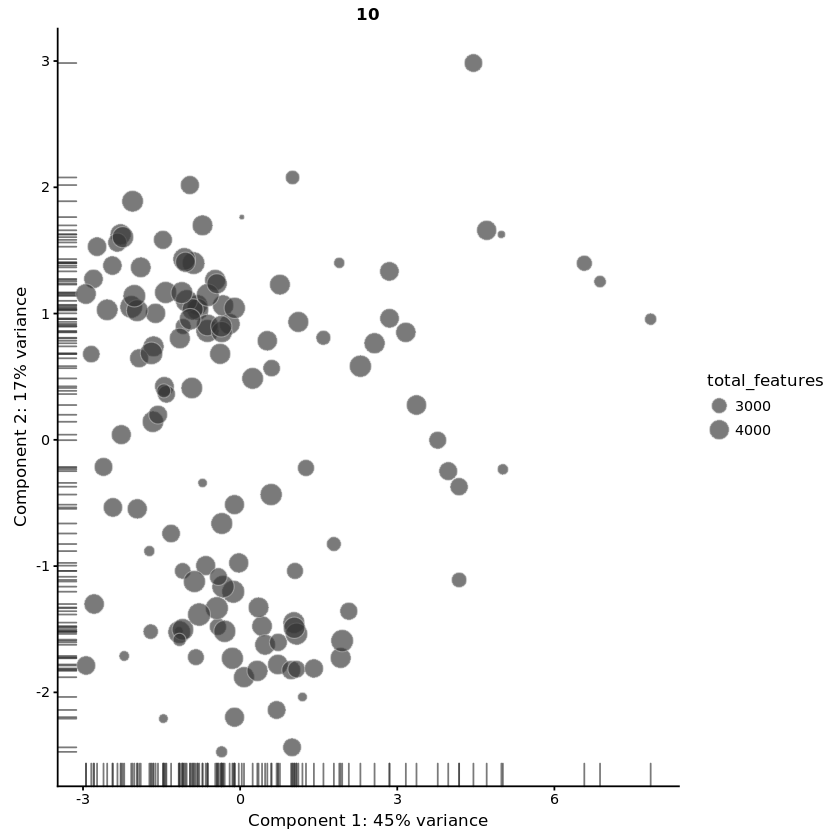

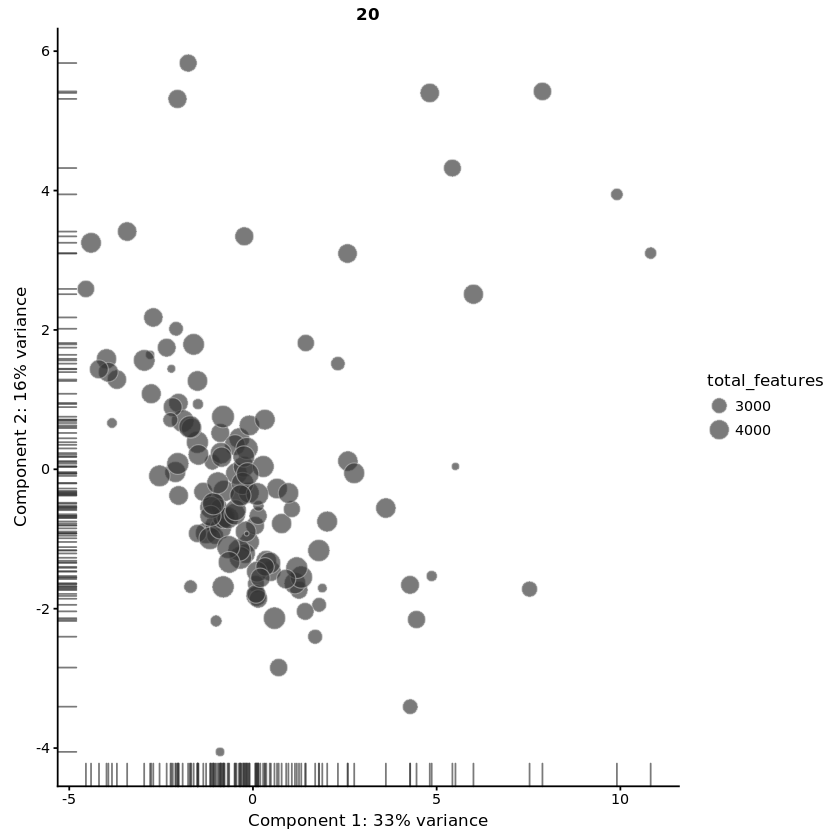

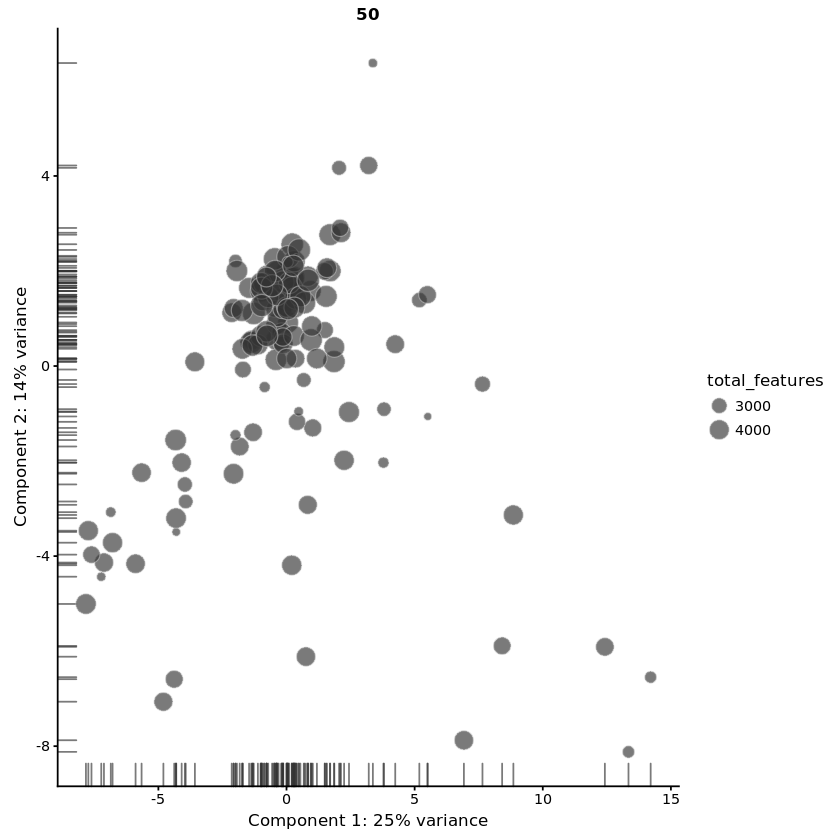

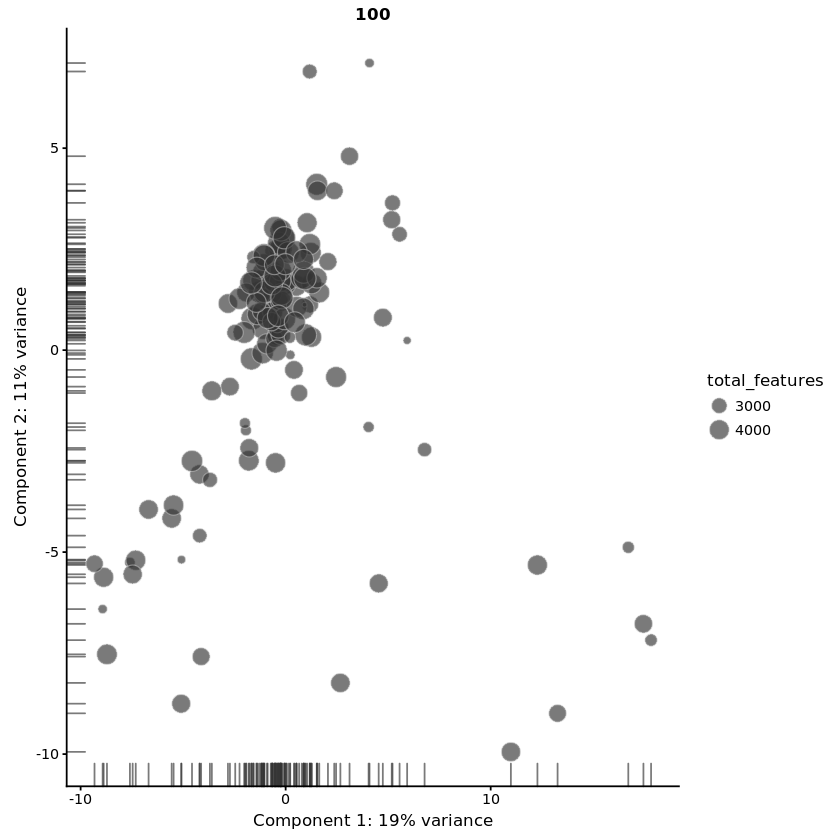

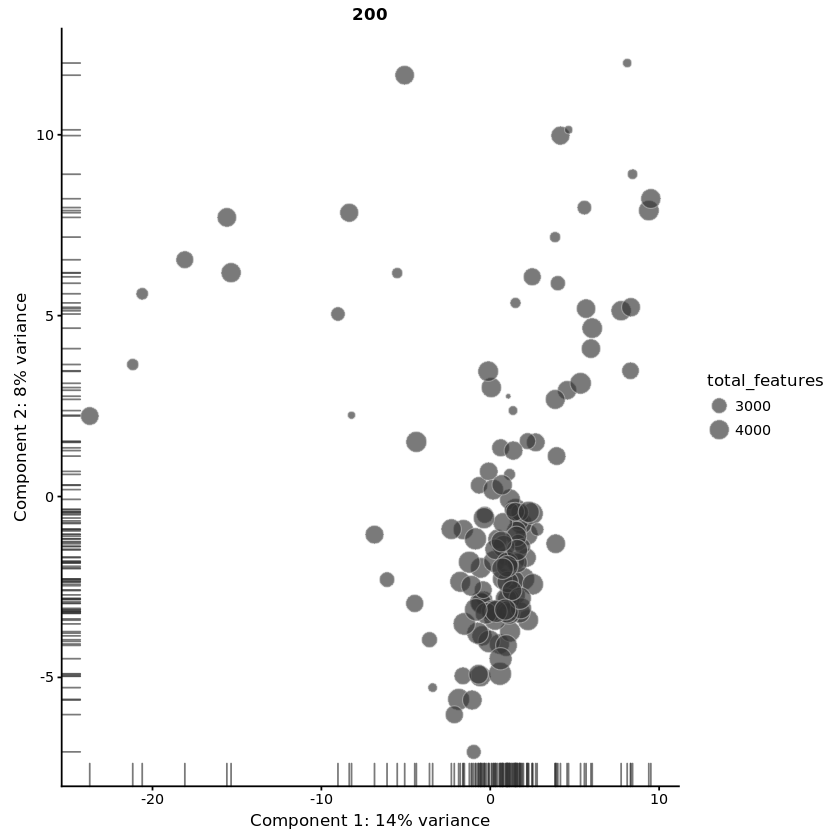

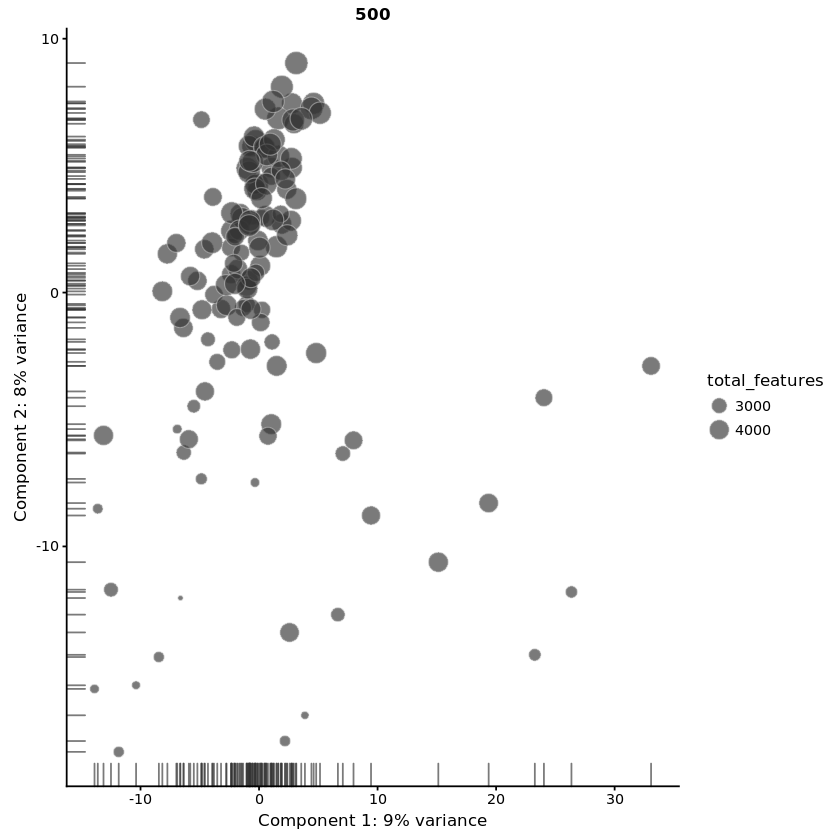

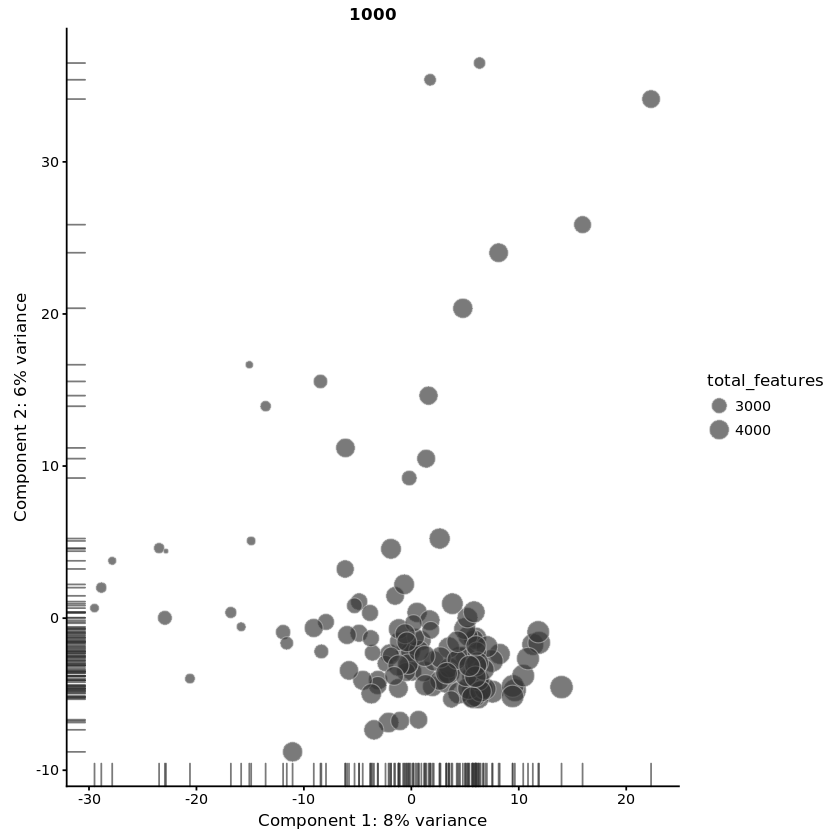

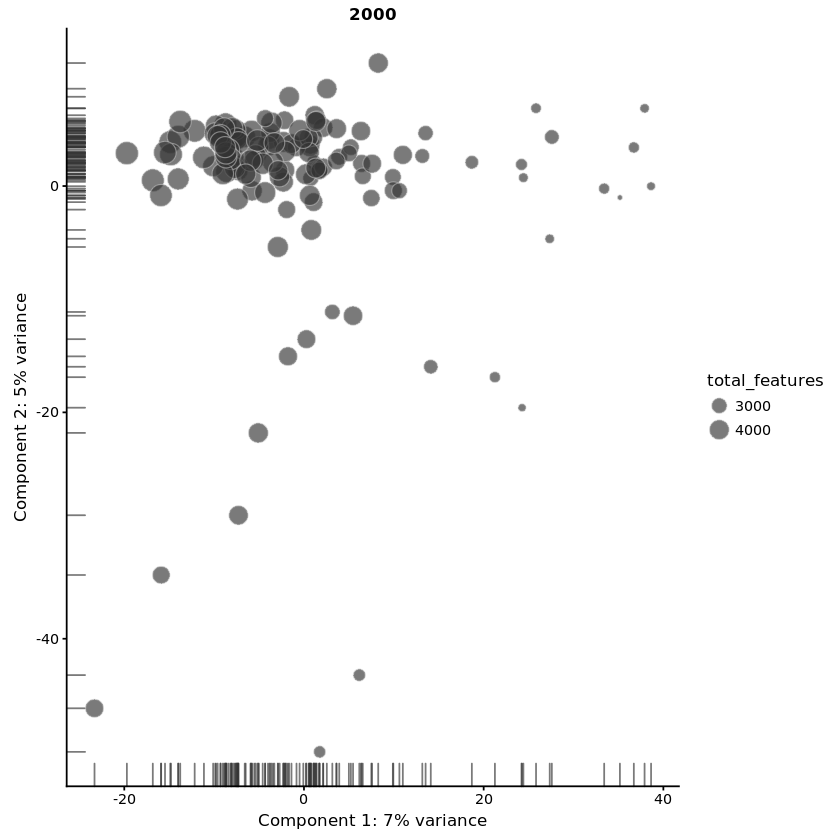

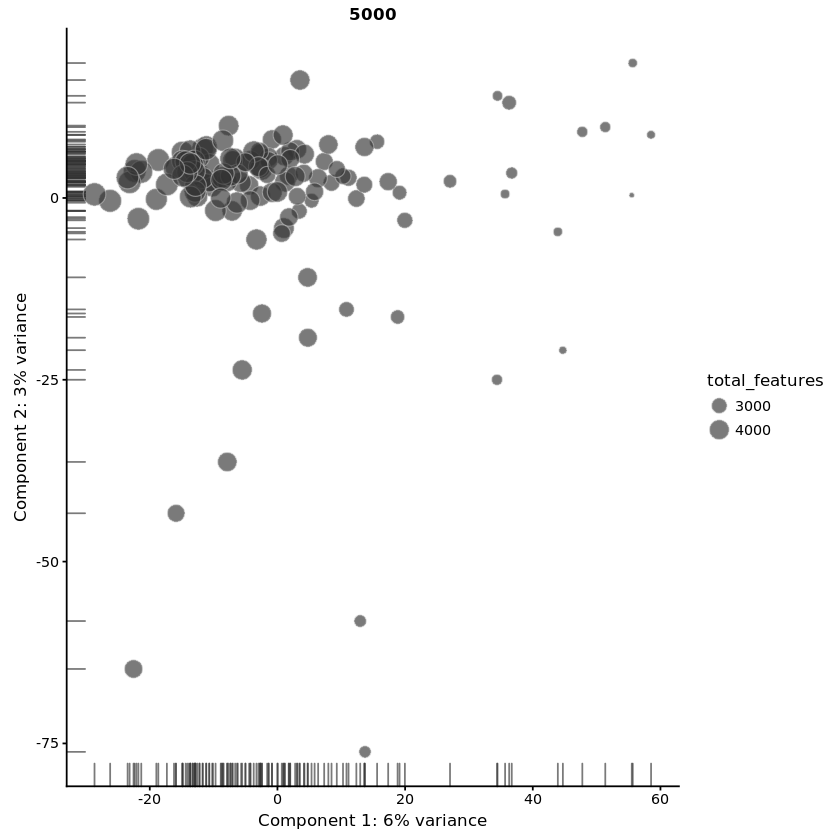

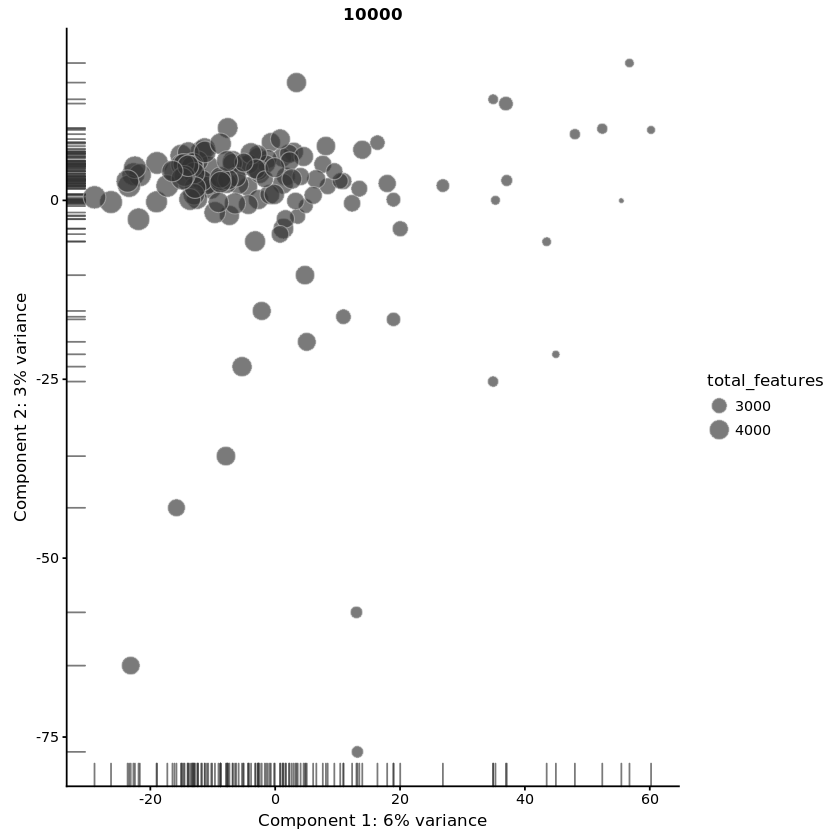

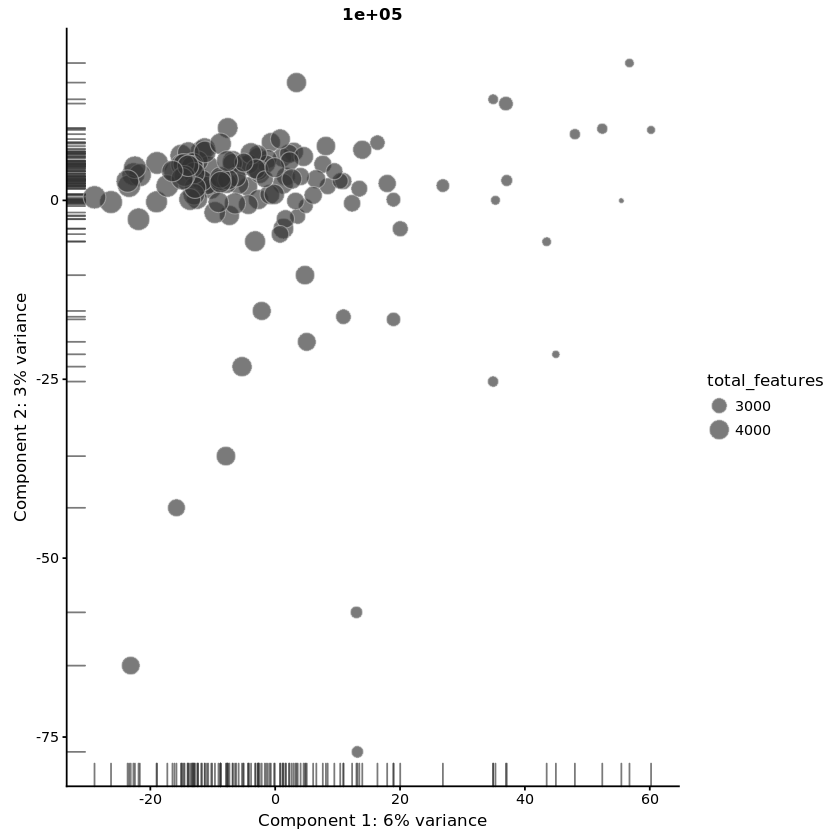

In [3]:
for (top in c(3,5,10,20,50,100,200,500,1e3,2e3,5e3,1e4,1e5)){
    
    ## - Interestingly, the plot flips axes between 1225 and 1226. But the clusters are
    ##   the same, so this is not a significant feature.
    ## for (top in seq(1220,1230)){     
    sce <- runPCA(sce, ntop = top, ncomponents = 2)
    print(
        plotPCA(
            sce, 
            exprs_values = "logcounts",
            ncomponents=2,
            size_by = "total_features"
#            colour_by = sprintf("sc3_%d_clusters", 5)
        ) + ggtitle(paste(top))
    )
}

From this we can see that from just the first 3-10 genes, we have a variance of more than 50% in our first component, and we can see the fuzzy outlines of two groups.

Once we consider the 20+ genes, the plots take on a more central clustering with outliers dotted around it.

So we have two main clustering profiles defined as `ntop < 20` and `ntop >= 20`, with the clearest examples of each being `ntop = 5` and `ntop = 2000`

We shall now attempt to fit the various SC3 clusters to these two profiles, taking into account the first 3 PCs for brevity..

## Ntop = 5

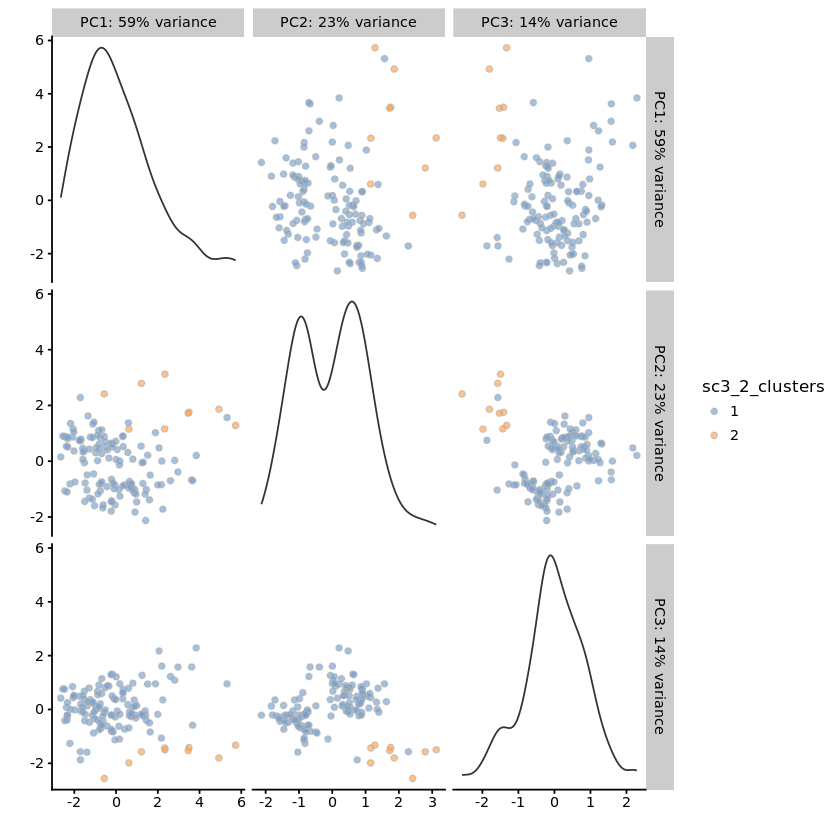

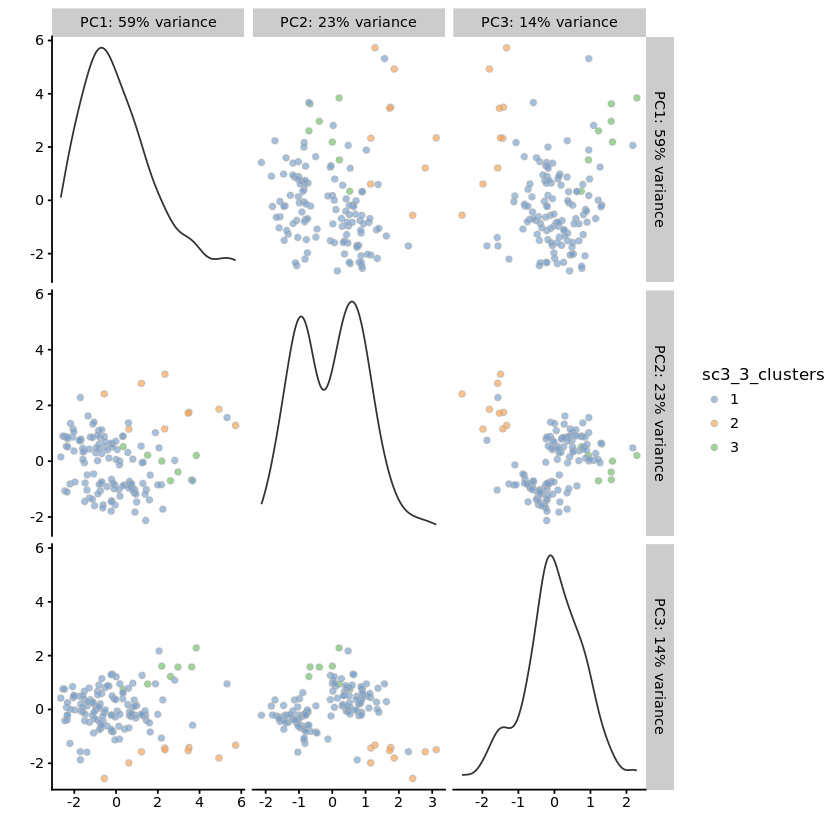

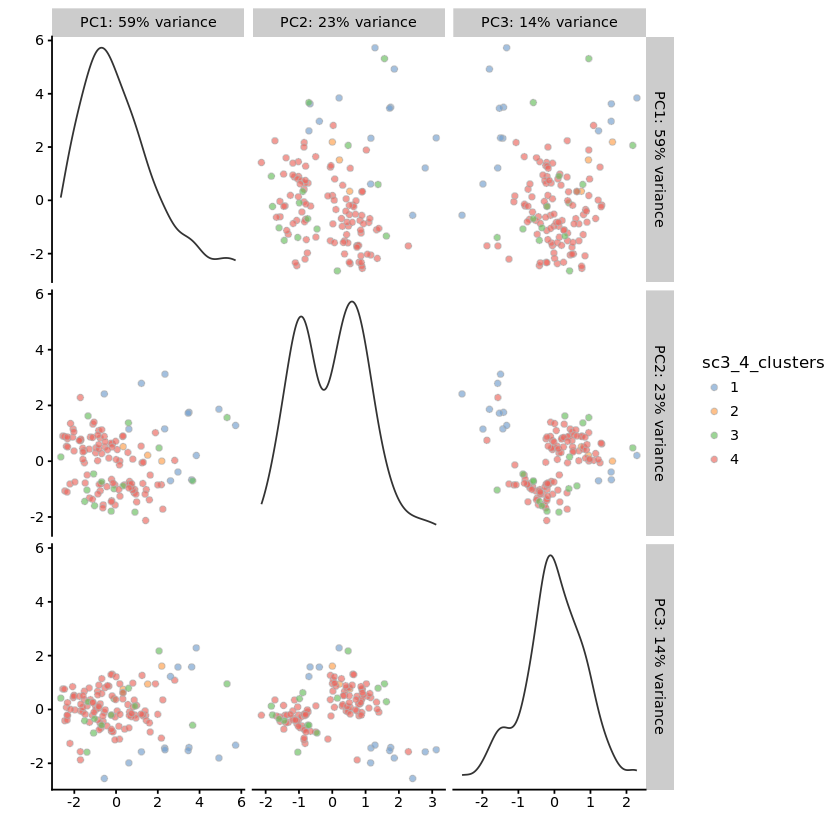

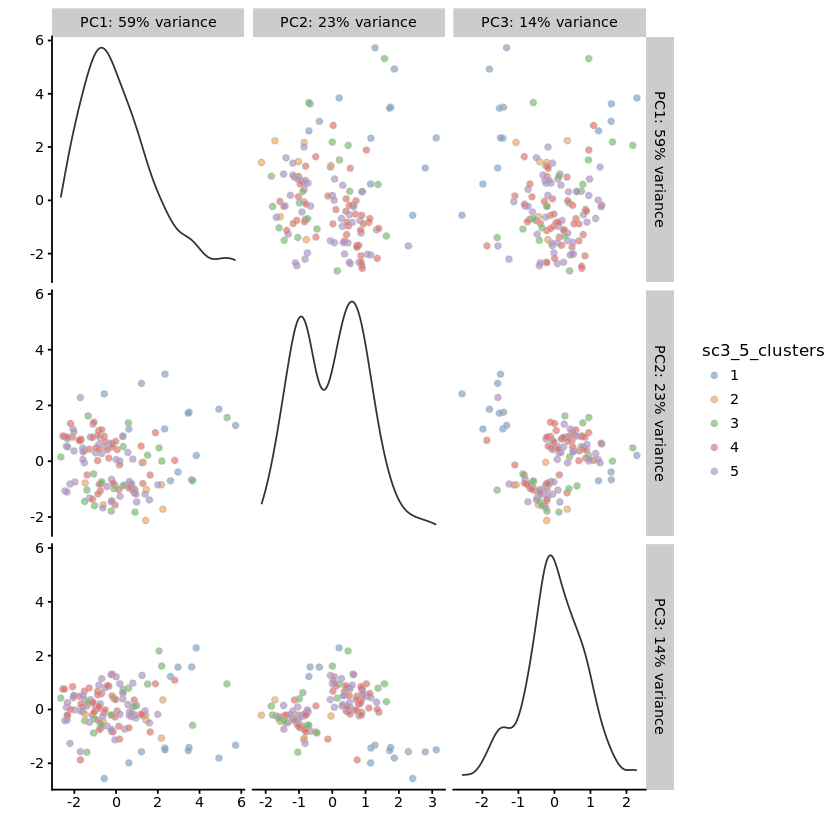

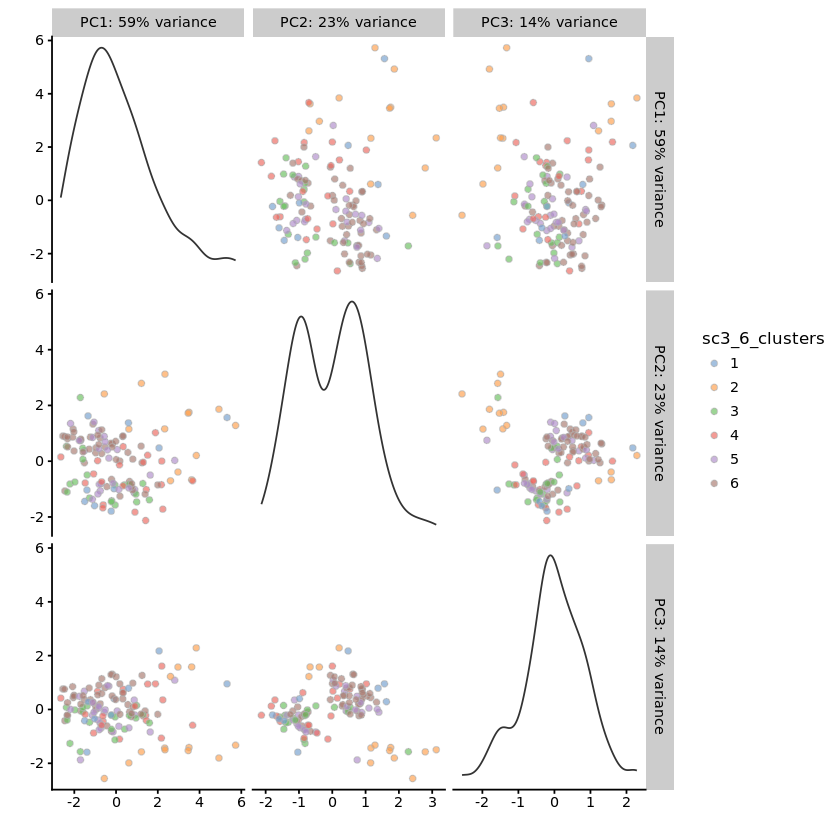

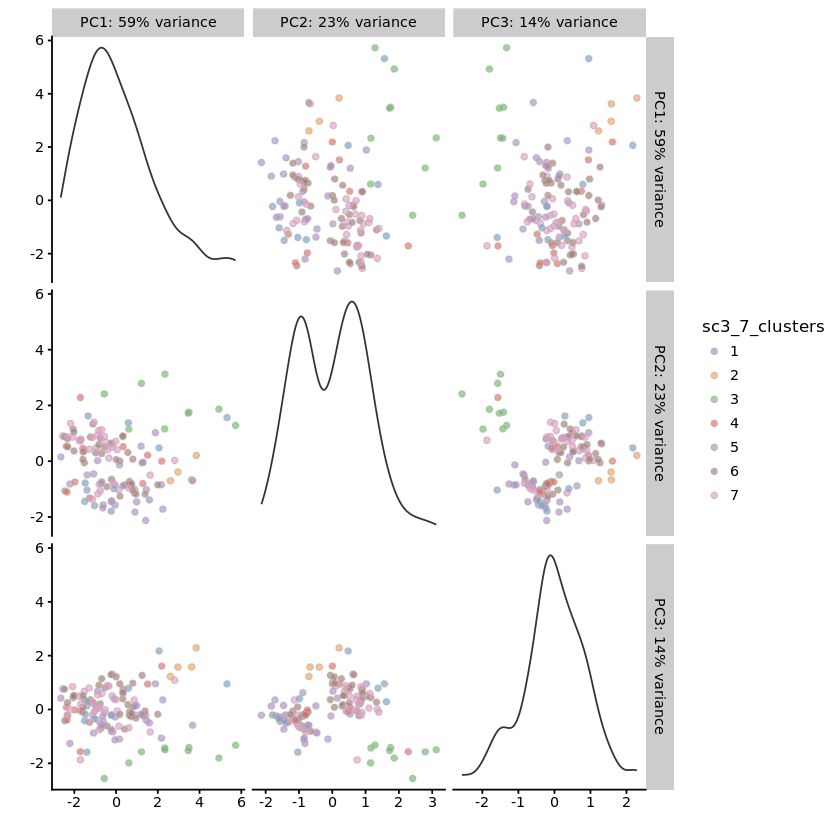

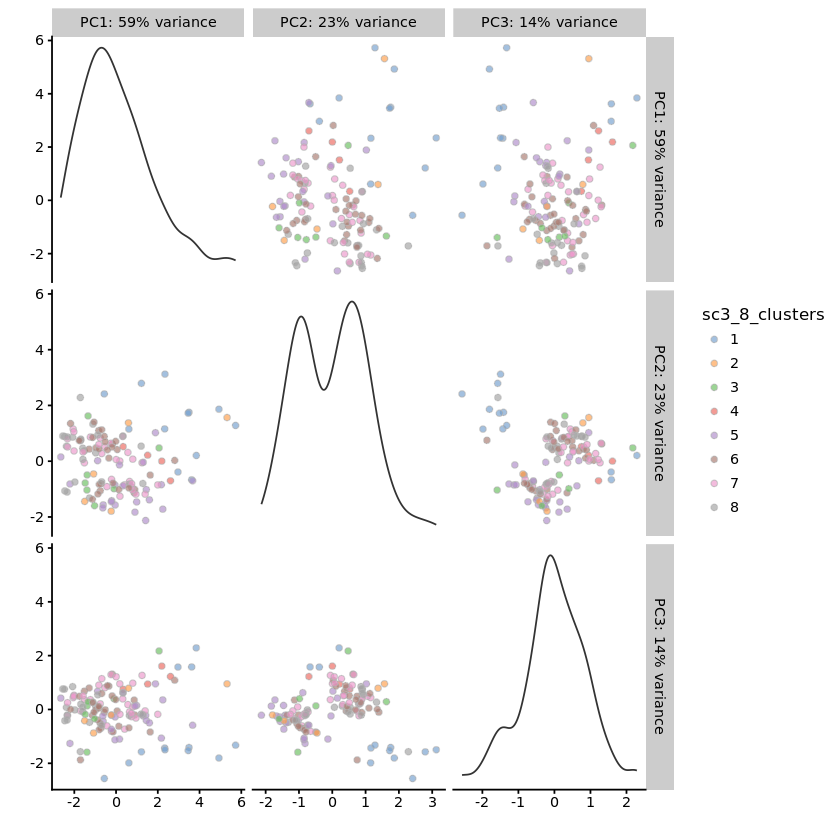

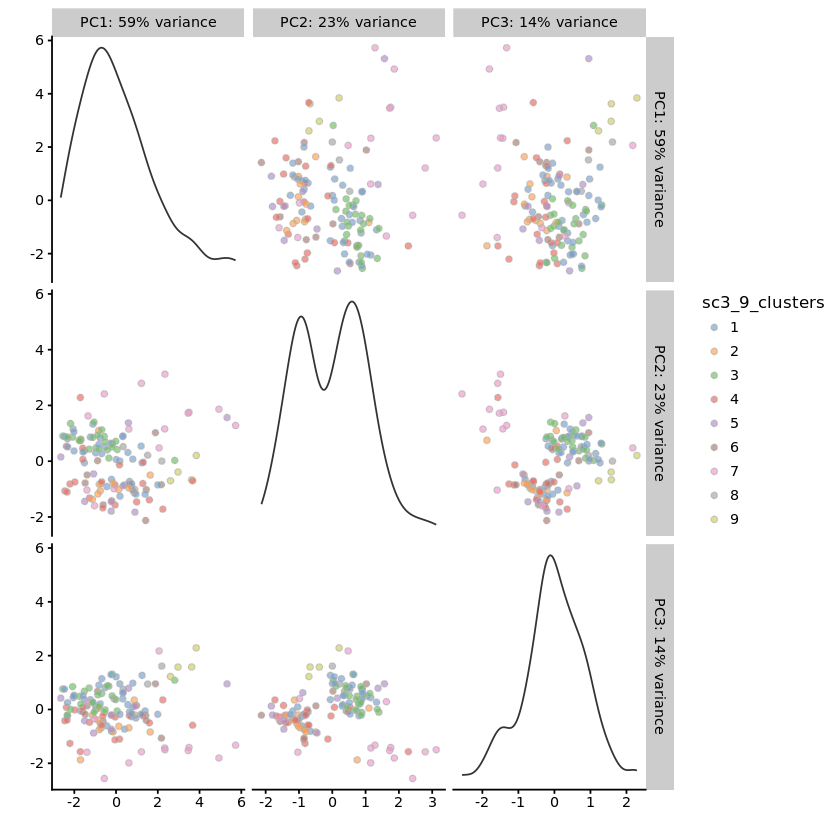

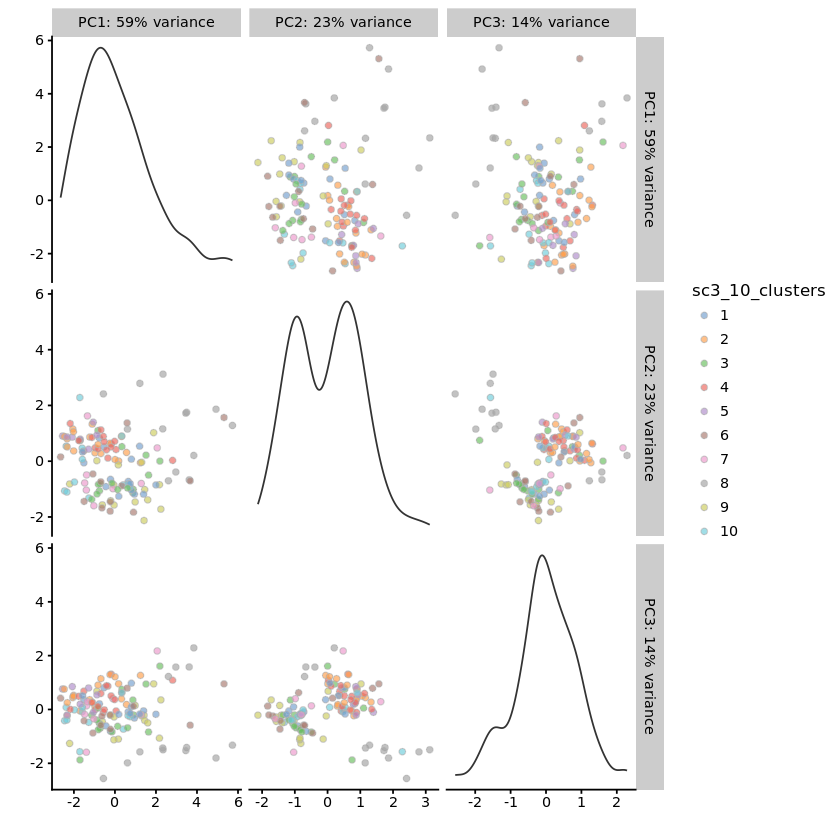

In [4]:
# Perform dimension reduction via PCA
sce <- runPCA(sce, ntop = 5, ncomponents = 3)

for (k in 2:10){
    print(
        plotPCA(
            sce, 
            exprs_values = "logcounts",
            ncomponents=3,
            colour_by = sprintf("sc3_%d_clusters", k)))
}

Unfortunately it looks like the two main clusters do not seperate nicely for any of the computed SC3 values, which treats the two clusters as the same up to k = 4, and then disintegrates into noise.

## Ntop = 2000

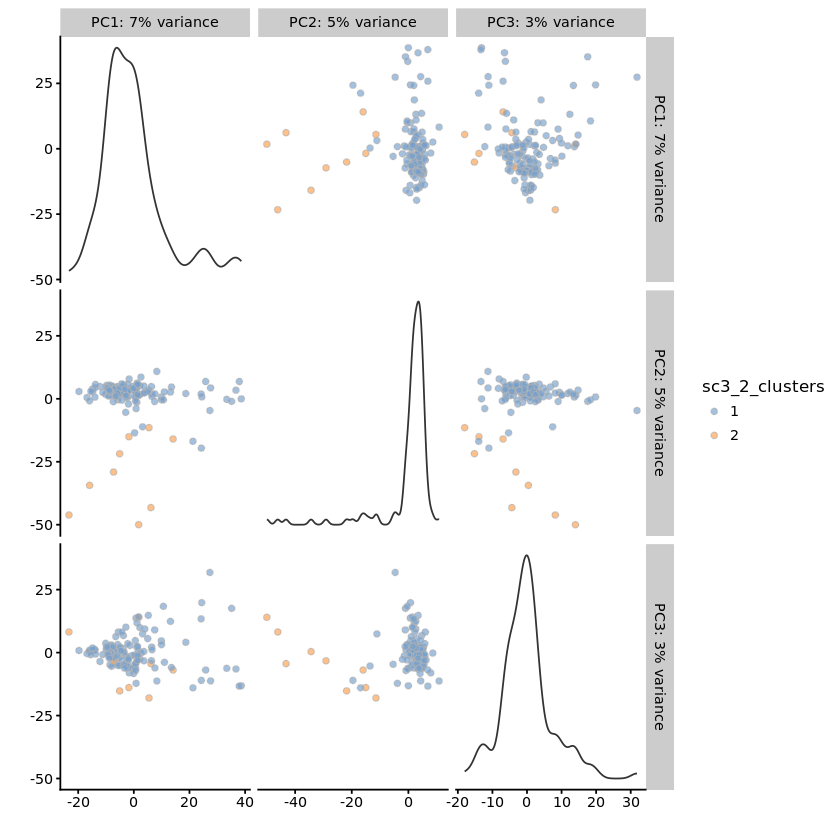

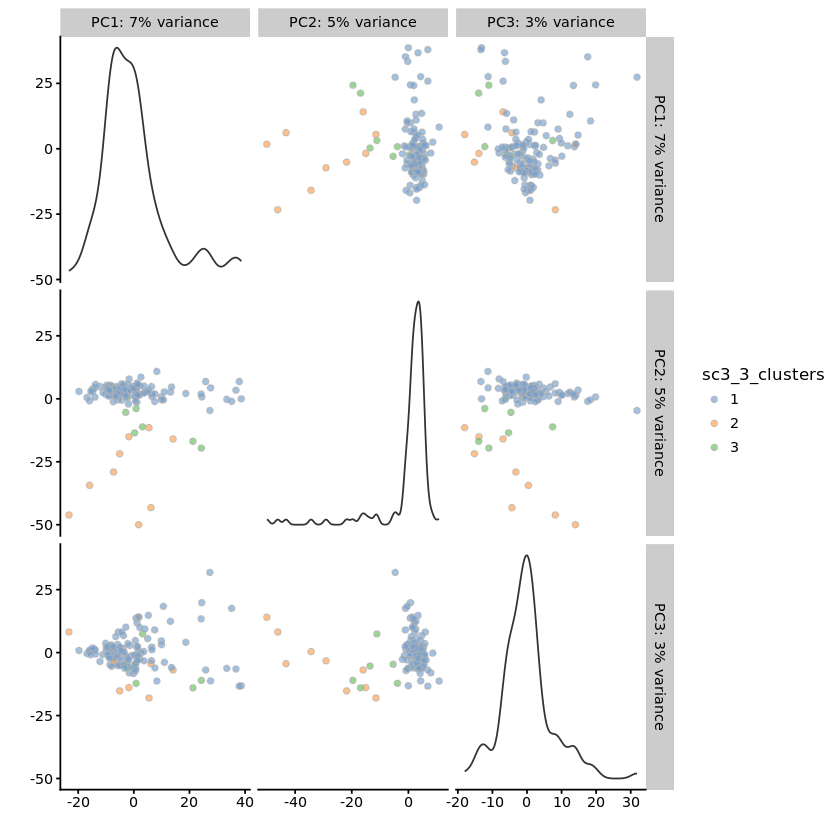

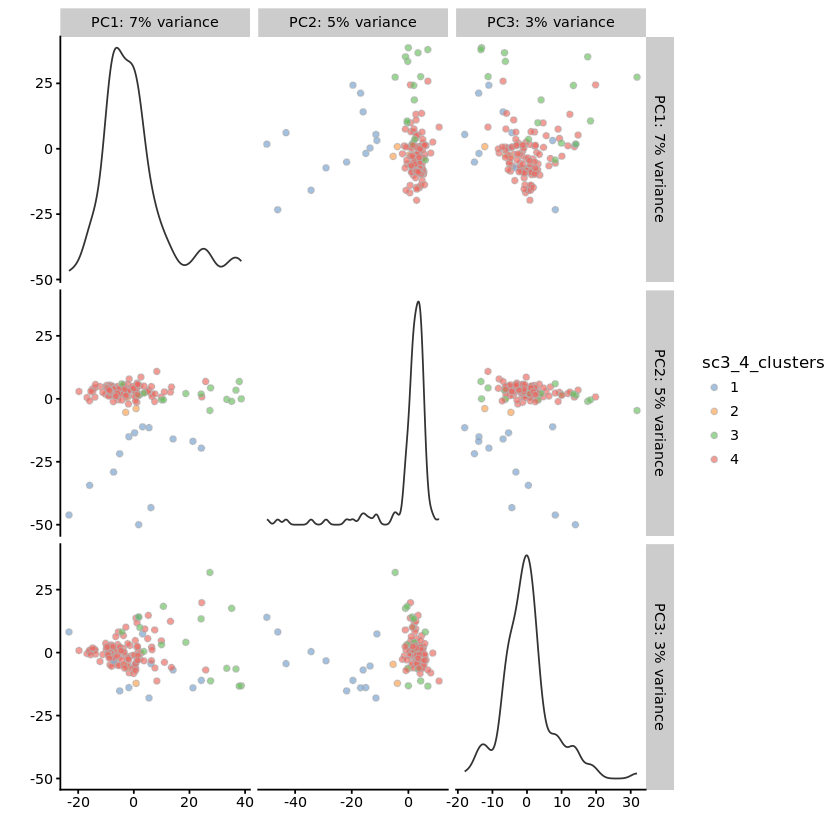

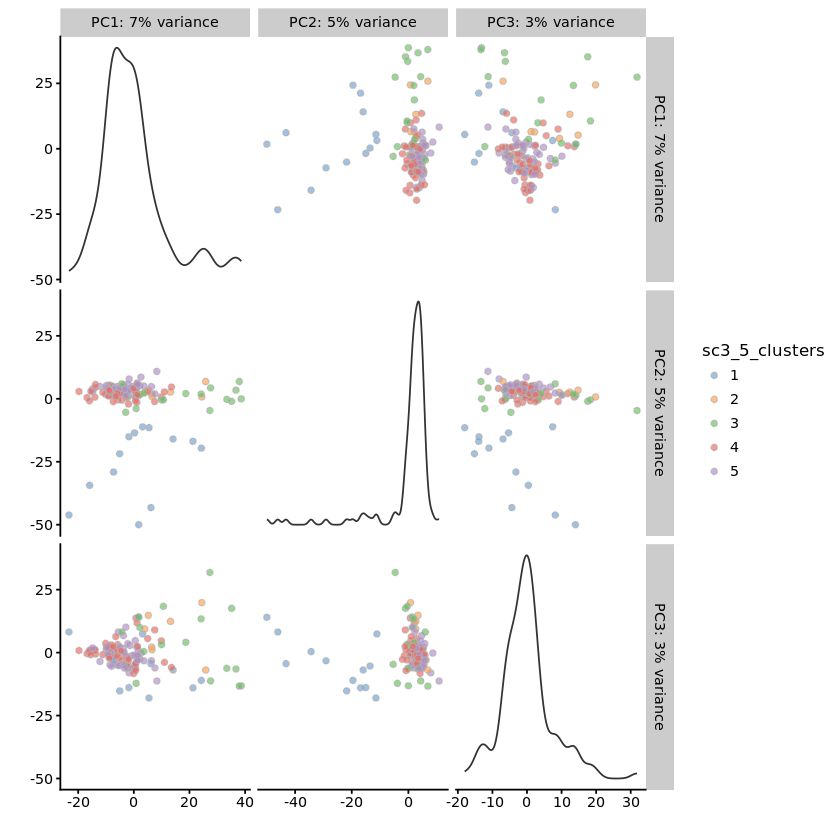

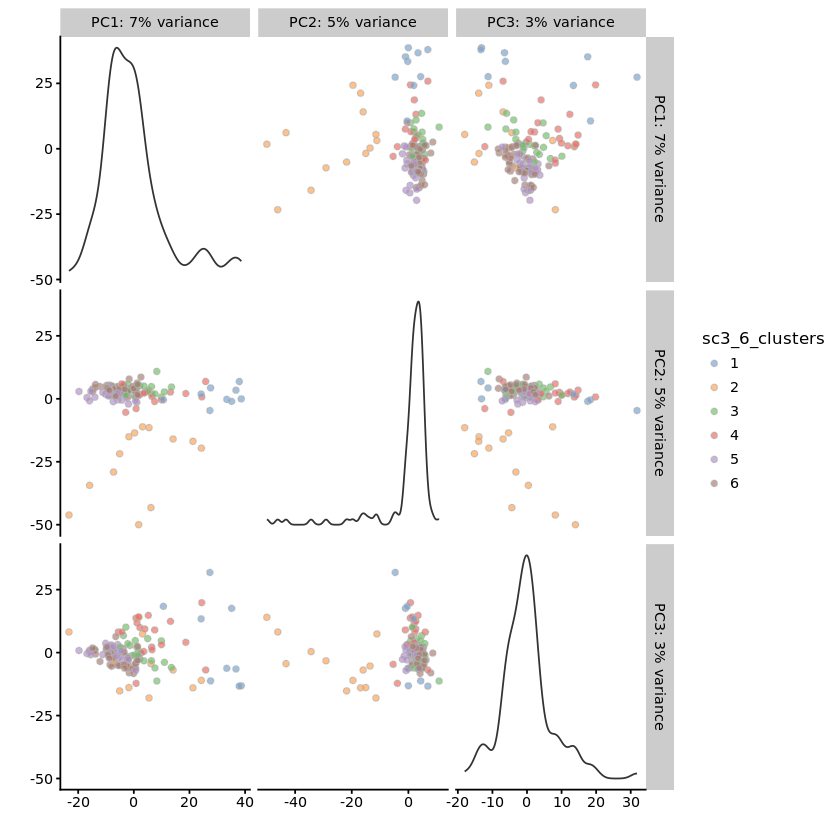

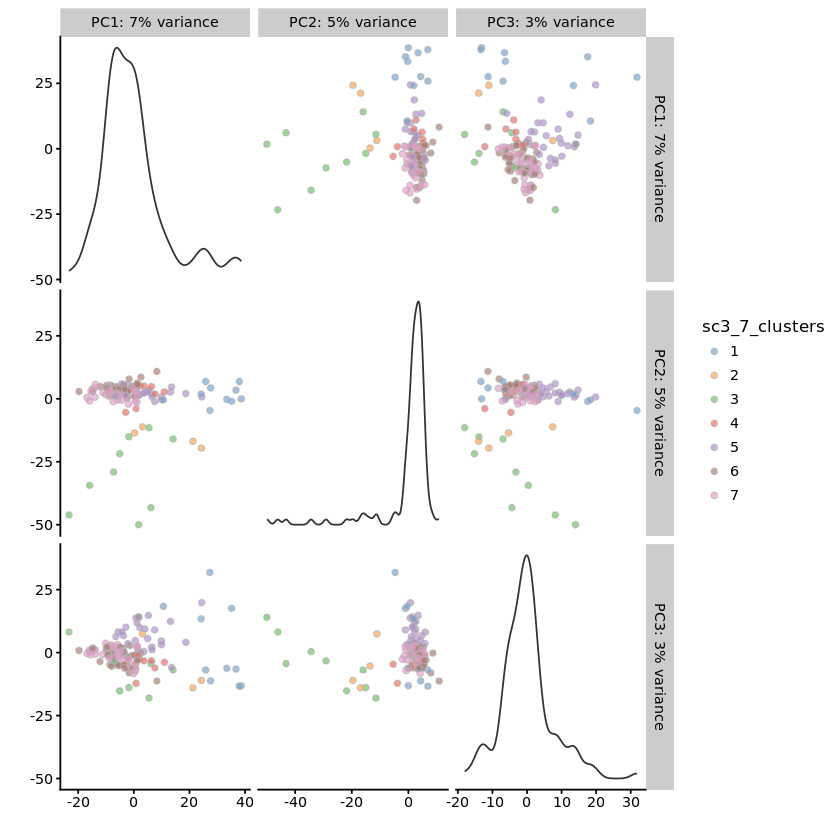

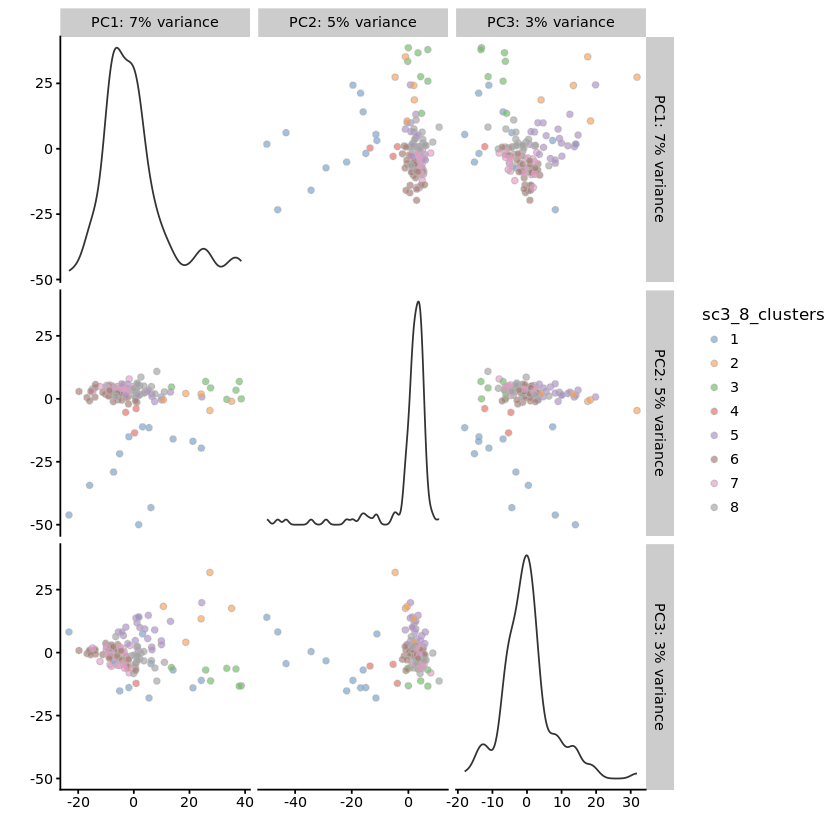

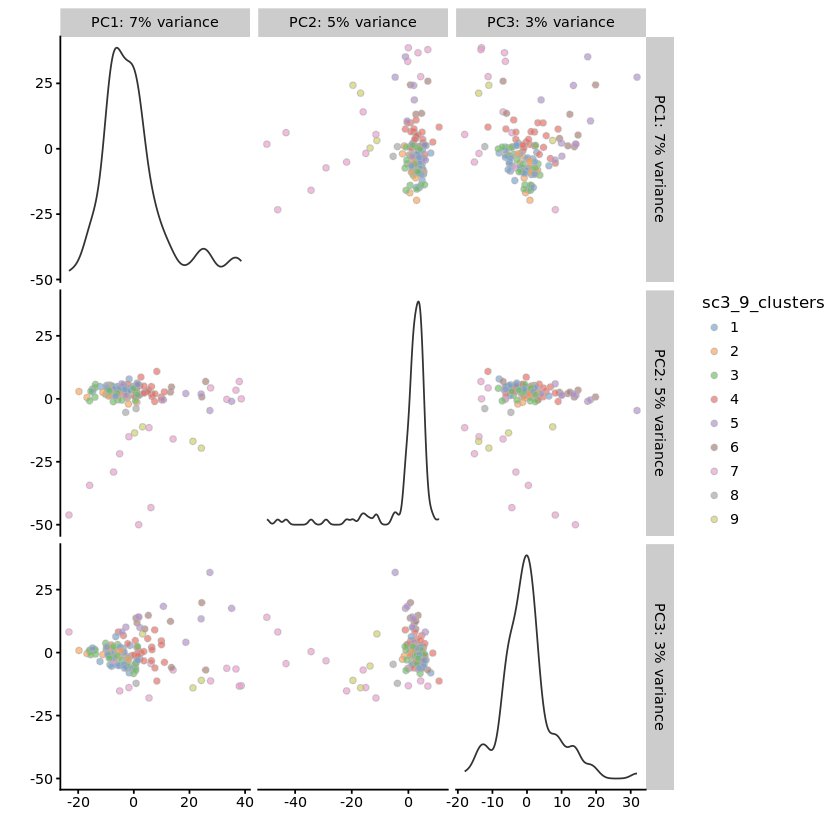

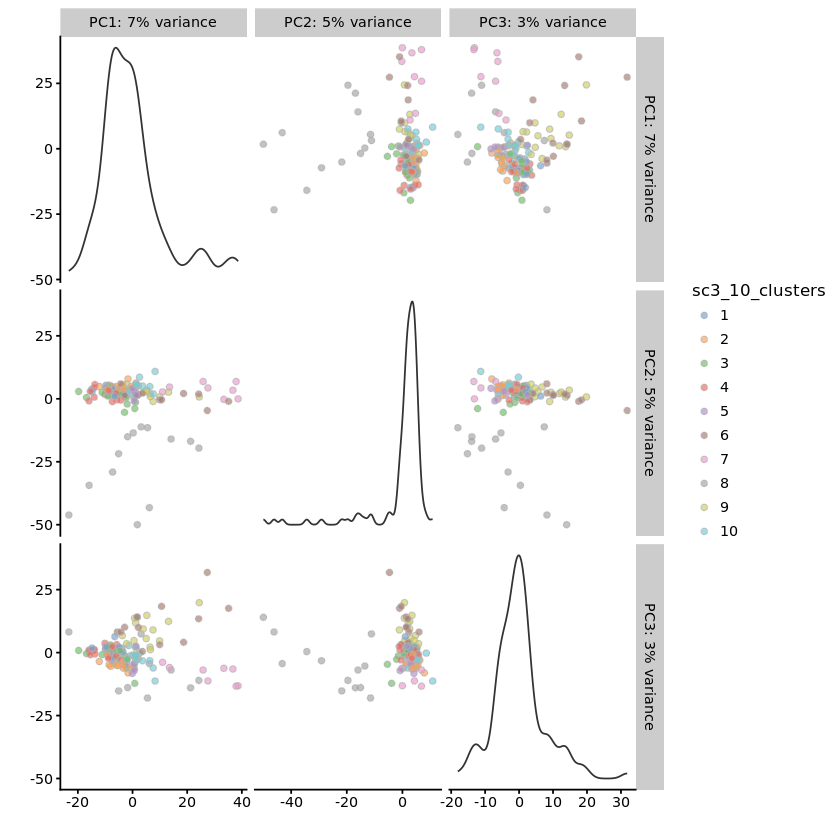

In [5]:
# Perform dimension reduction via PCA
sce <- runPCA(sce, ntop = 2000, ncomponents = 3)

for (k in 2:10){
    print(
        plotPCA(
            sce, 
            exprs_values = "logcounts",
            ncomponents=3,
            colour_by = sprintf("sc3_%d_clusters", k)))
}

Several features to note:
 * From **k = 2** an outlier group is defined (orange) which persists into the higher k values.
 * From **k = 5** we see tightly-bound sub-groups within the main cluster that seperates from the more noisy outliers that were previously defined in the group.
 * From **k = 7** we see tidy seperations
 * From **k = 8** outliers start to mix noisily
 * The first two PCs were enough to define the clustering.
 
Let us look at the most interesting SC3 clusters (k=4,5,6,7) but over a similar range of top DE genes as previous, to see how our clusters change when more genes are included:





k = 4


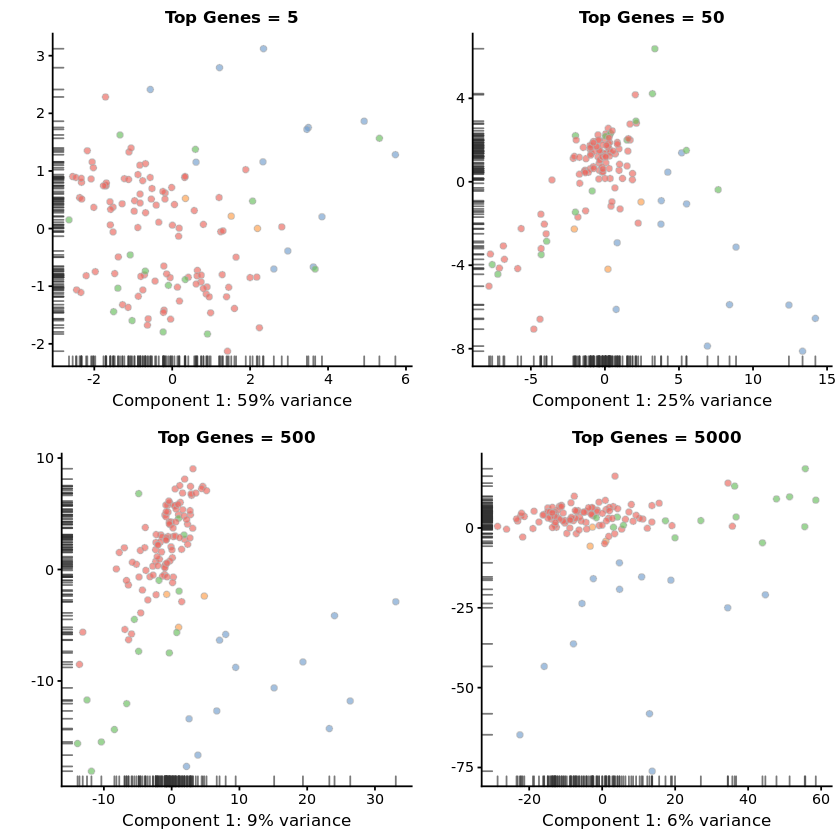





k = 5


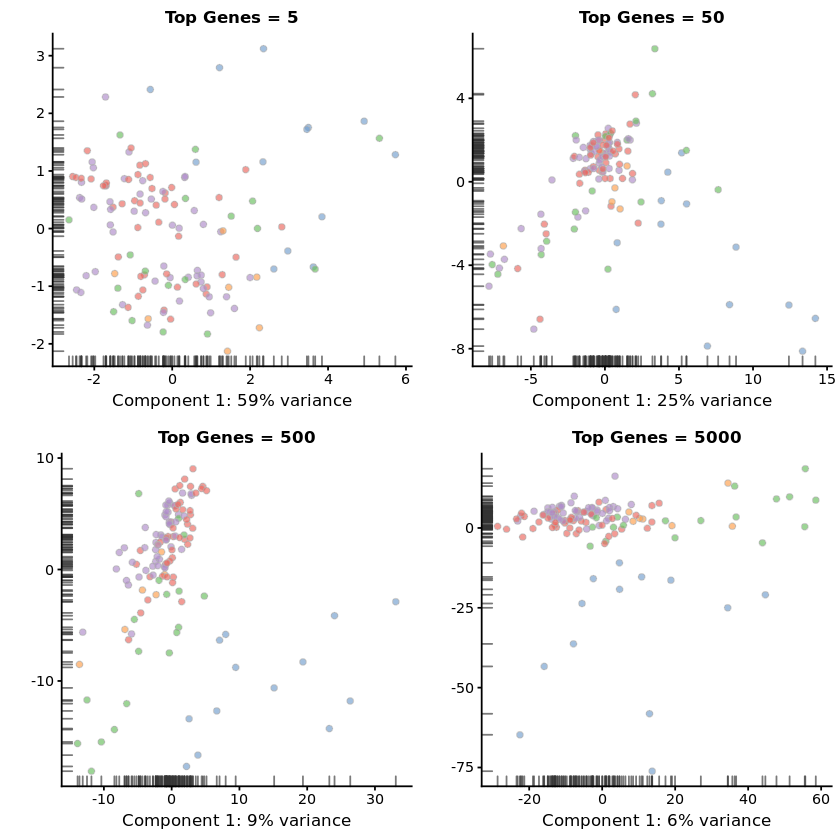





k = 6


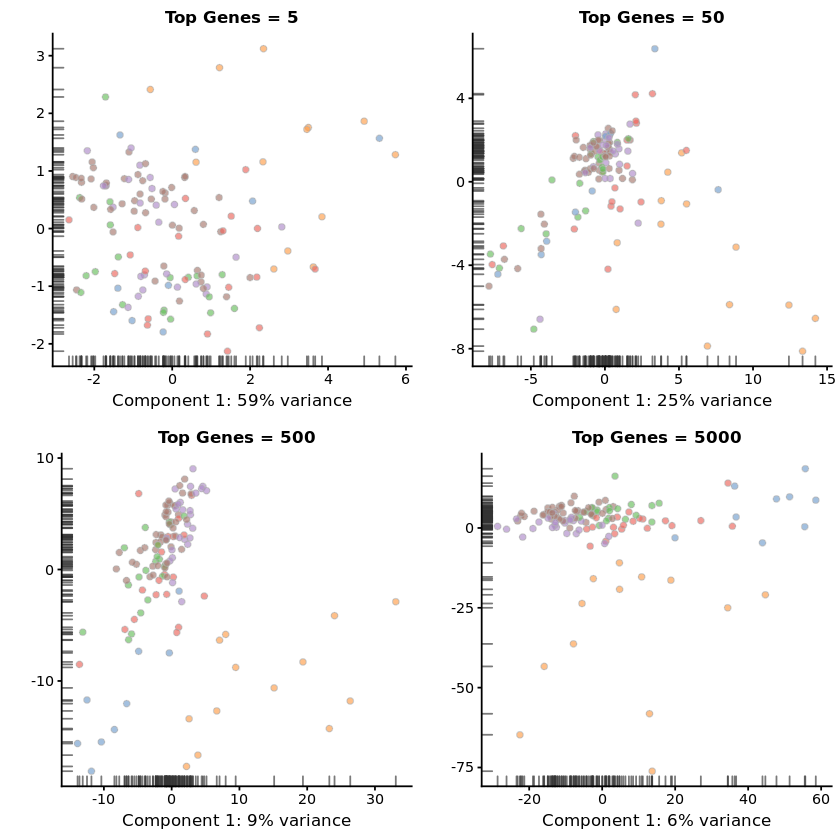





k = 7


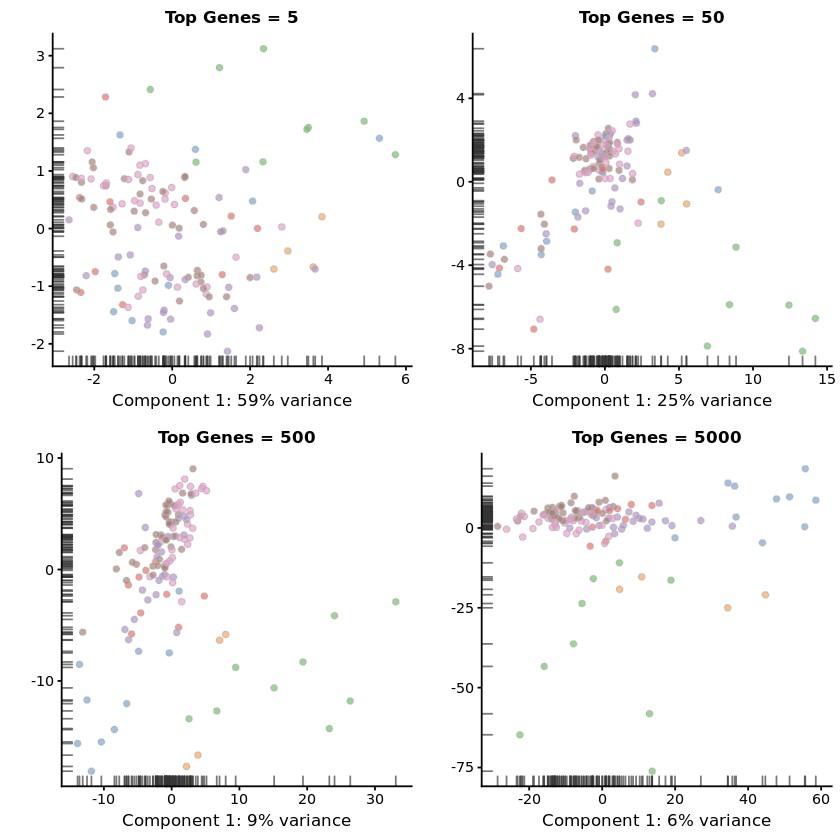

In [6]:
printInteresting <- function(kval, ntoppers){
    multiplot(plotlist = (
        lapply(ntoppers, function(x){
            
            sce <- runPCA(sce, ntop = x, ncomponents = 2)
            
            return(plotPCA(
                sce, exprs_values = "logcounts", ncomponents=2, 
                colour_by = sprintf("sc3_%d_clusters", kval)
            ) + guides(fill=F
            ) + ggtitle(sprintf("Top Genes = %.0f", x)
            ) + ylab("") 
            )
        })
    ), layout = rbind(c(1,2),c(3,4) ) #,c(5,6),c(7,8))
    )
    cat(sprintf("\n\n\n\nk = %.0f\n", kval))
}

ntoppers <- c(5,50,500,5000)

printInteresting(4, ntoppers)
printInteresting(5, ntoppers)
printInteresting(6, ntoppers)
printInteresting(7, ntoppers)

 * The k=4 plots seem the clearest in defining the main cluster, but it also encapsulates some of the more sparse outliers. 
 * The k=5 plots seem to delimit the outliers better (two groups: blue and orange, with sparse inclusion in the main cluster), but it also splits the main cluster into subgroups (which may or may not be desirable).
 * The k=6 plots segment the outliers even better, with less inclusion of outliers in the main cluster
 * The k=7 plots splits the main cluster into too many subgroups.

It is also clear to see that the plots make the most sense when we consider all genes, and not just the most expressive (top genes = 5000 > top genes = 50).


# Exploring the cell-types

We will select the K=6 plots, and try to quantify the different cell types. Let us examine the expression plots once more.

In [7]:
suppressWarnings(library(SC3))

Warning message in runPCA(sce, ntop = 5000, ncomponents = 2, detect_outliers = T):
“outlier detection requires 'pca_data_input="coldata"'”

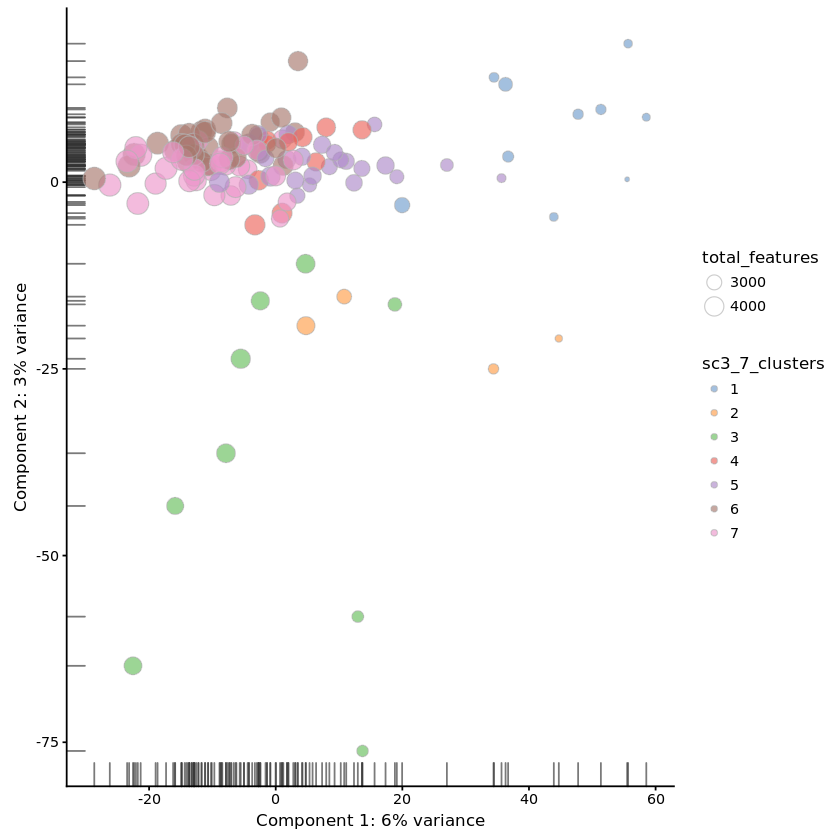

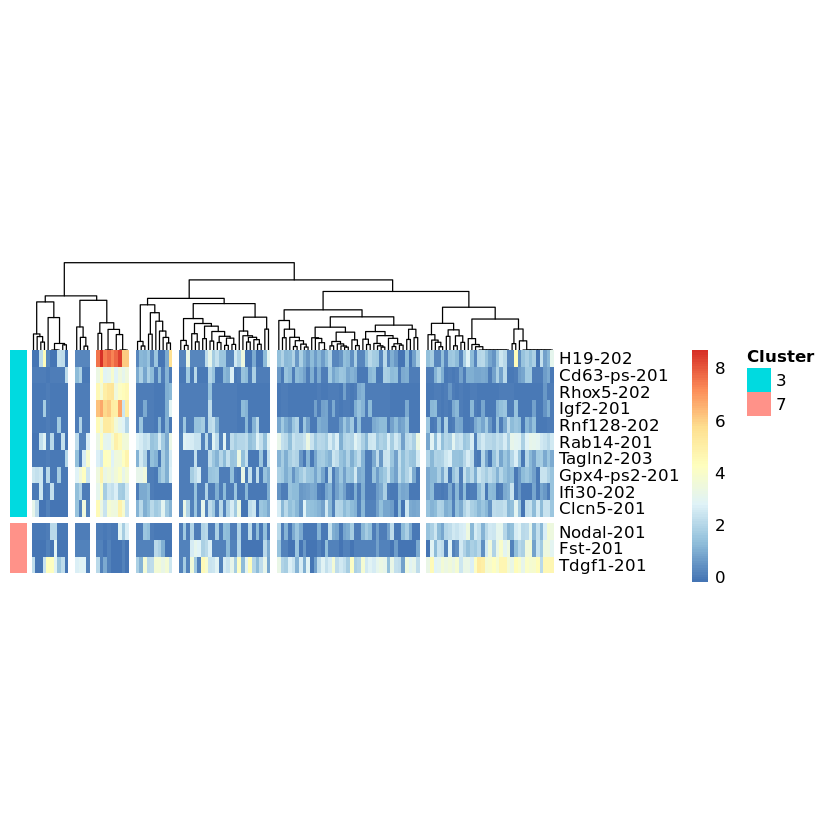

In [8]:
kay = 7
sce <- runPCA(sce, ntop = 5000, ncomponents = 2, detect_outliers = T)

plotPCA(
   sce,
   size_by = "total_features",
   colour_by = sprintf("sc3_%.0f_clusters", kay)
)
               
              
#res <- 
sc3_plot_markers(sce, kay)
#res[4][1]$gtable
#res[4][1]
#grepl("odal", res[4])
#grepl("odal", res[4][1])

#Nodal protein coding), Fst, Tdgf1
#Gpx4, N4bp2, Abhd17b, Tmx1, Cst3, Gsto1, Rhox5, Npc2, Atp6ap1, Ifi30, 
#Lars2
